In [1]:
import evaluate
from datasets import *
import numpy as np
import pathlib as pl
import pandas as pd
import torch
import ast
import os
from haystack.document_stores import FAISSDocumentStore
from haystack.nodes import DensePassageRetriever, Seq2SeqGenerator
from haystack.nodes.answer_generator.transformers import _BartEli5Converter
from haystack.pipelines import Pipeline

YEAR = 2020
DPR_FINE_TUNE = False

MODEL_PATH = "../../data/models/T5"

In [2]:
generated_data = load_dataset('csv', data_files=f"../../data/clean/sustainability-report-{YEAR}-squad-format.csv",
                    delimiter=";", split='train').train_test_split(test_size=0.3, shuffle=True, seed=42)

generated_data["test"] = generated_data["test"].map(
    lambda example: ast.literal_eval(example["answers"]))
generated_data["test"] = generated_data["test"].map(lambda example: {"question": example["question"], "context": example["context"], "answers": {
                                  "text": example["text"], "answer_start": example["answer_start"]}})
generated_data["test"] = generated_data["test"].map(lambda example: {"question": example["question"].replace("\n", " "), "context": example["context"].replace("\n", " "), "answers": {
                                "text": [example["answers"]["text"][0].replace("\n", " ")], "answer_start": example["answers"]["answer_start"]}})
generated_data["test"].remove_columns(["text", "answer_start"])

Found cached dataset csv (C:/Users/rjutr/.cache/huggingface/datasets/csv/default-dc9275c3697e5cc0/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
Loading cached split indices for dataset at C:\Users\rjutr\.cache\huggingface\datasets\csv\default-dc9275c3697e5cc0\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-0b40be795cd765b7.arrow and C:\Users\rjutr\.cache\huggingface\datasets\csv\default-dc9275c3697e5cc0\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-3e1cf7e5eca93f71.arrow
Loading cached processed dataset at C:\Users\rjutr\.cache\huggingface\datasets\csv\default-dc9275c3697e5cc0\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-1e92815268136ea2.arrow
Loading cached processed dataset at C:\Users\rjutr\.cache\huggingface\datasets\csv\default-dc9275c3697e5cc0\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-21e74bfcddde162b.arrow
Loading cached process

Dataset({
    features: ['question', 'context', 'answers', 'id'],
    num_rows: 56
})

In [3]:
bertscore = evaluate.load("bertscore")
bleu = evaluate.load("bleu")

In [4]:
document_store = FAISSDocumentStore.load(index_path="document_store.faiss", config_path="document_store.json")

In [5]:
if DPR_FINE_TUNE:
    retriever = DensePassageRetriever.load(load_dir=f"../../data/models/DPR/{YEAR}", document_store=document_store, use_gpu=True)
else: 
    retriever = DensePassageRetriever(
        document_store=document_store,
        query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
        passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
        use_gpu=True
    )

c:\Users\rjutr\miniconda3\envs\project_ds_2\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizerFast'.


In [6]:
# Set the device
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

# Define the prediction function
def inference_answer(model, question):
    question = question
    with torch.no_grad():
        outputs = model.run(query=question, params={"Model": {"top_k": 3}})
    return outputs["answers"][0].answer

In [7]:
models = os.listdir(MODEL_PATH)

In [8]:
results = {
    "Model": [],
    "Data": [],
    "Bert.Precision": [],
    "Bert.Recall": [],
    "Bert.F1": [],
    "BLEU": []
}

In [9]:
generated_answer_true = [generated_data["test"]["answers"][idx]["text"][0] for idx in range(generated_data["test"].shape[0])]

In [10]:
generator = None
pipe = None

for model in models:
    model_data = model.split("-")
    year = model_data[-2]

    if int(year) != YEAR:
        continue

    print(f"Evaluating model {model}...")
    model_name = "-".join(model_data[:2])
    data_name = model_data[-1]

    generator = Seq2SeqGenerator(model_name_or_path=f"{MODEL_PATH}/{model}", input_converter=_BartEli5Converter(), use_gpu=True)
    pipe = Pipeline()
    pipe.add_node(component=retriever, name="Retriever", inputs=["Query"])
    pipe.add_node(component=generator, name="Model", inputs=["Retriever"])

    results["Model"].append(model_name)
    results["Data"].append(data_name)

    answer_pred = [inference_answer(pipe, generated_data["test"]["question"][idx]) for idx in range(generated_data["test"].shape[0])]

    results_1 = bertscore.compute(predictions=answer_pred, references=generated_answer_true, lang="en")
    results_2 = bleu.compute(predictions=answer_pred, references=generated_answer_true)

    results["Bert.Precision"].append(np.array(results_1["precision"]).mean())
    results["Bert.Recall"].append(np.array(results_1["recall"]).mean())
    results["Bert.F1"].append(np.array(results_1["f1"]).mean())
    results["BLEU"].append(results_2["bleu"])

    del generator
    del pipe
    torch.cuda.empty_cache()

Evaluating model t5-base-finetuned-squadv2-finetuned-NLB-QA-2020-full...
Evaluating model t5-base-finetuned-squadv2-finetuned-NLB-QA-2020-smaller...
Evaluating model t5-small-finetuned-squadv2-finetuned-NLB-QA-2020-full...
Evaluating model t5-small-finetuned-squadv2-finetuned-NLB-QA-2020-smaller...


In [11]:
results_df = pd.DataFrame(results)

## Base DPR

In [12]:
results_df

,Model,Data,Bert.Precision,Bert.Recall,Bert.F1,BLEU
0,t5-base,full,0.915469,0.917890,0.916450,0.0
1,t5-base,smaller,0.909035,0.918337,0.913346,0.0
2,t5-small,full,0.925505,0.920455,0.922855,0.0
3,t5-small,smaller,0.925812,0.918026,0.921762,0.0


## DPR Finetunned

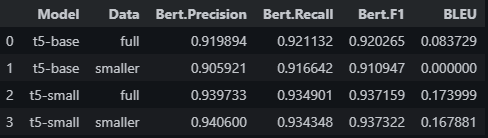